In [100]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
% matplotlib inline

import nengo
import nengo_spa as spa

from nengo_learn_assoc_mem.utils import norm_spa_vecs

In [2]:
def numpy_bytes_to_str(lst):
    return [l.decode('utf-8') for l in lst]

In [3]:
with h5py.File("../data/fami_ia_full.h5py", "r") as fi:
    print(list(fi.keys()))
    inp = np.array(fi['input'])
    output = np.array(fi['output'])
    
    fan1 = numpy_bytes_to_str(fi['fan1'])
    fan2 = numpy_bytes_to_str(fi['fan2'])
    foil1 = numpy_bytes_to_str(fi['foil1'])
    foil2 = numpy_bytes_to_str(fi['foil2'])
    
    v_strs = numpy_bytes_to_str(fi['vocab_strings'])
    v_vecs = list(fi['vocab_vectors'])
    D = fi['vocab_vectors'].attrs['dimensions']
    
    accum = np.array(fi['accum'])
    clean = np.array(fi['clean'])
    clean_accum = np.array(fi['clean_accum'])
    de_out = np.array(fi['de_out'])

    dt = fi['t_range'].attrs['dt']
    t_range = np.arange(fi['t_range'][0], fi['t_range'][1], dt)
    t_pause = fi['t_range'].attrs['t_pause']
    t_present = fi['t_range'].attrs['t_present']

['accum', 'clean', 'clean_accum', 'correct', 'de_out', 'fan1', 'fan2', 'foil1', 'foil2', 'input', 'output', 't_range', 'vocab_strings', 'vocab_vectors']


In [4]:
t_each = t_pause + t_present

In [5]:
vocab = spa.Vocabulary(D)
for val, vec in zip(v_strs, v_vecs):
    vocab.add(val, vec)

In [6]:
fan1_pair_vecs = norm_spa_vecs(vocab, fan1)
fan2_pair_vecs = norm_spa_vecs(vocab, fan2)
foil1_pair_vecs = norm_spa_vecs(vocab, foil1)
foil2_pair_vecs = norm_spa_vecs(vocab, foil2)

In [7]:
fan1_win = slice(int(t_pause / dt), int((len(fan1) * t_each + t_pause) / dt))
fan2_win = slice(fan1_win.stop, fan1_win.stop + int((len(fan2) * t_each) / dt))
foil1_win = slice(fan2_win.stop, fan2_win.stop + int((len(foil1) * t_each) / dt))
foil2_win = slice(foil1_win.stop, foil1_win.stop + int((len(foil2) * t_each) / dt))

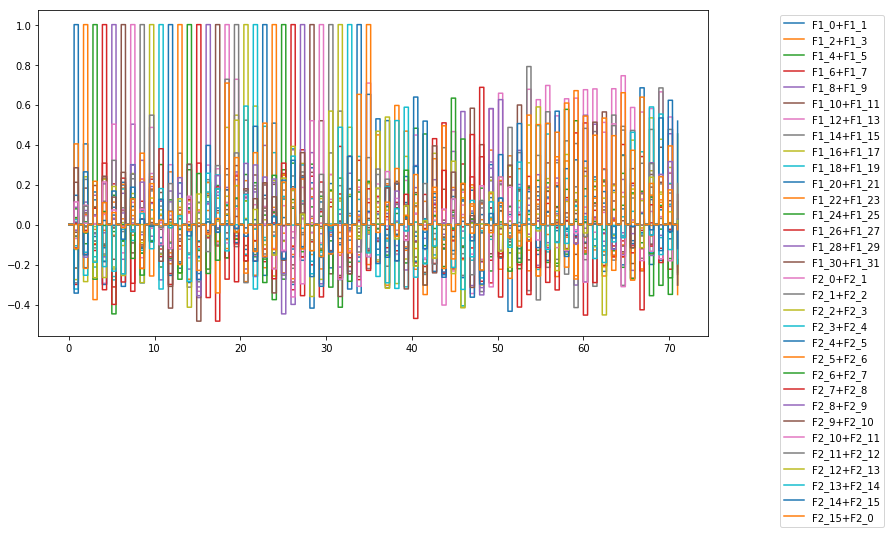

In [114]:
plt.figure(figsize=(12, 6))
plt.plot(t_range, spa.similarity(inp, fan1_pair_vecs+fan2_pair_vecs))
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

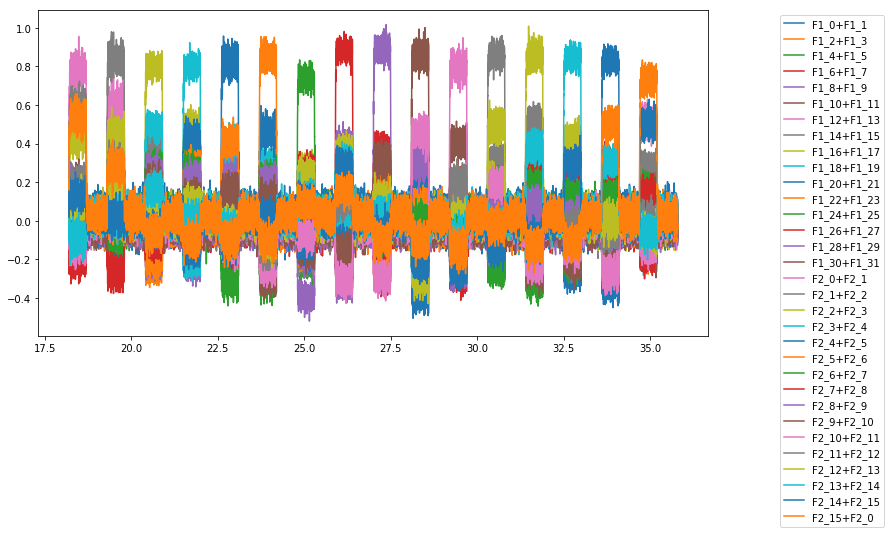

In [9]:
plt.figure(figsize=(12, 6))
plt.plot(t_range[fan2_win], spa.similarity(de_out, fan1_pair_vecs+fan2_pair_vecs)[fan2_win])
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

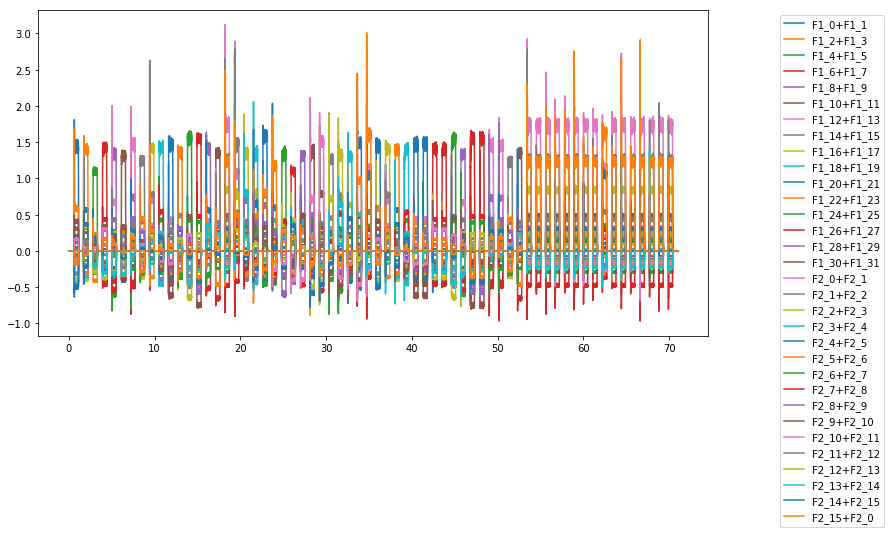

In [115]:
plt.figure(figsize=(12, 6))
plt.plot(t_range, spa.similarity(clean, fan1_pair_vecs+fan2_pair_vecs))
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

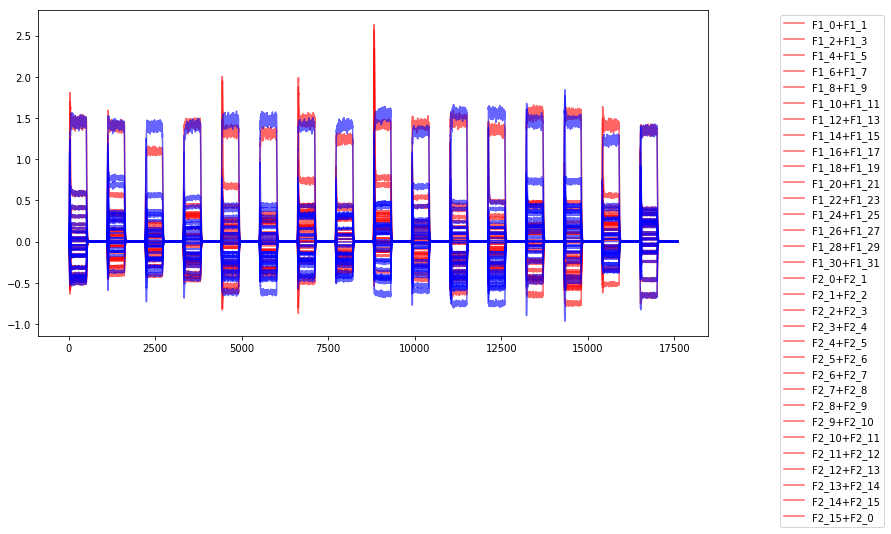

In [121]:
plt.figure(figsize=(12, 6))
plt.plot(spa.similarity(clean[fan1_win], fan1_pair_vecs+fan2_pair_vecs), alpha=0.6, color='r')
plt.plot(spa.similarity(clean[foil1_win], fan1_pair_vecs+fan2_pair_vecs), alpha=0.6, color='b')
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

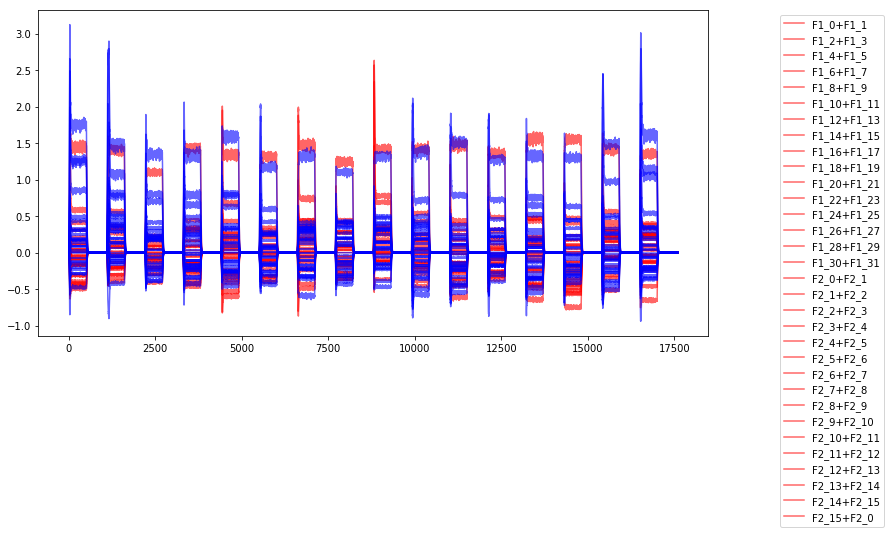

In [122]:
plt.figure(figsize=(12, 6))
plt.plot(spa.similarity(clean[fan1_win], fan1_pair_vecs+fan2_pair_vecs), alpha=0.6, color='r')
plt.plot(spa.similarity(clean[fan2_win], fan1_pair_vecs+fan2_pair_vecs), alpha=0.6, color='b')
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

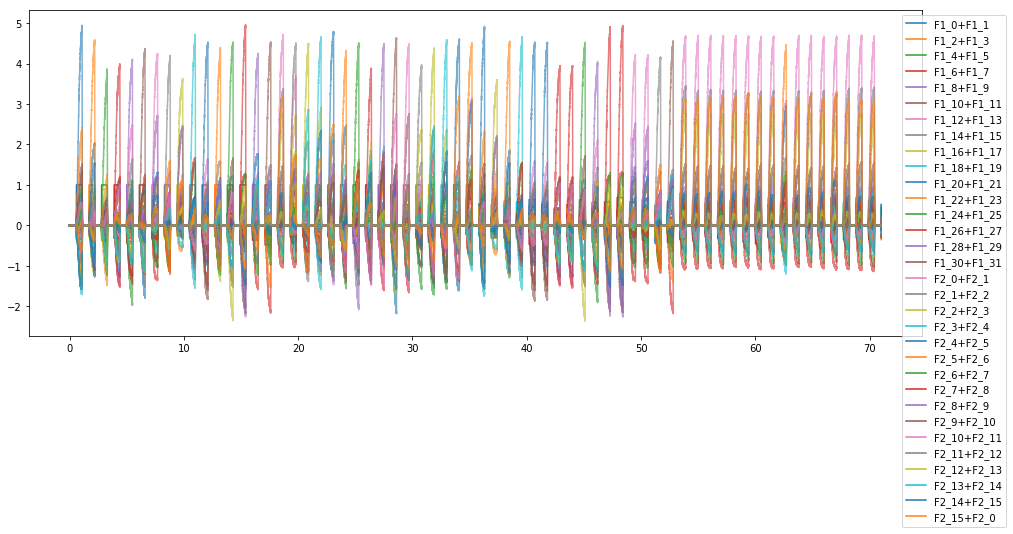

In [116]:
plt.figure(figsize=(16, 6))
plt.plot(t_range, spa.similarity(inp, fan1_pair_vecs+fan2_pair_vecs))
plt.gca().set_prop_cycle(None)
plt.plot(t_range, spa.similarity(accum, fan1_pair_vecs+fan2_pair_vecs), alpha=0.6)
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))

(18.2, 35.800000000000004)

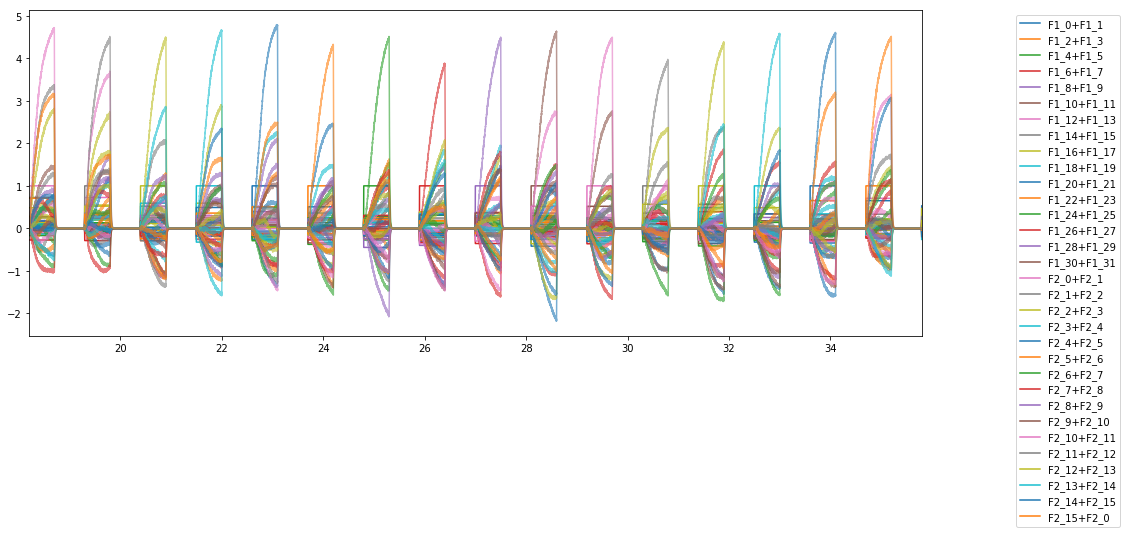

In [62]:
plt.figure(figsize=(16, 6))
plt.plot(t_range[fan2_win], spa.similarity(inp, fan1_pair_vecs+fan2_pair_vecs)[fan2_win])
plt.gca().set_prop_cycle(None)
plt.plot(t_range[fan2_win], spa.similarity(accum, fan1_pair_vecs+fan2_pair_vecs)[fan2_win], alpha=0.6)
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))
plt.xlim(fan2_win.start*dt, fan2_win.stop*dt)

# Reaction Time

FAN1 should be faster than FAN2. Should be minimal difference between FAN and FOIL.

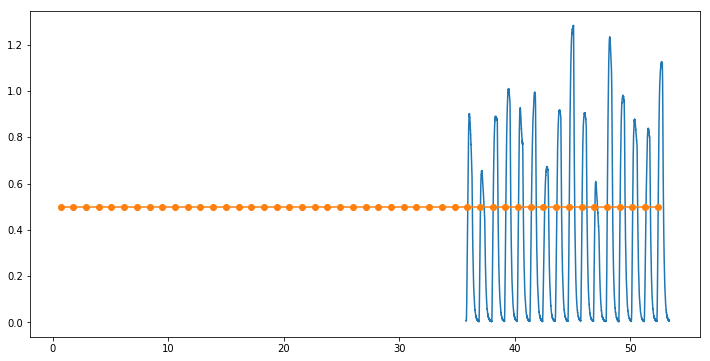

In [111]:
plt.figure(figsize=(12, 6))
plt.plot(t_range[foil1_win], output[foil1_win])
peak_idx = np.arange(int((t_pause+0.1)/dt), foil1_win.stop, int(t_each/dt))
peaks = t_range[peak_idx]
plt.plot(peaks, np.ones(peaks.shape)*0.5, linestyle=None, marker='o')

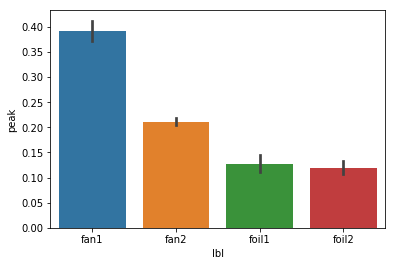

In [107]:
fan1_peak_idx = np.arange(int((t_pause+0.1)/dt), fan1_win.stop, int(t_each/dt))
fan2_peak_idx = np.arange(fan1_win.stop+int((t_pause+0.1)/dt), fan2_win.stop, int(t_each/dt))
foil1_peak_idx = np.arange(fan2_win.stop+int((t_pause+0.1)/dt), foil1_win.stop, int(t_each/dt))
foil2_peak_idx = np.arange(foil1_win.stop+int((t_pause+0.1)/dt), foil2_win.stop, int(t_each/dt))

peak_indices = (fan1_peak_idx, fan2_peak_idx, foil1_peak_idx, foil2_peak_idx)
labels = ("fan1", "fan2", "foil1", "foil2")

pk_list = []
peak_lbl = []
for lbl, idx in zip(labels, peak_indices):
    pk_list.append(output[idx])
    peak_lbl.extend([lbl] * len(idx))

all_peaks = np.concatenate(pk_list, axis=0).flatten()

pd_peak = pd.DataFrame({"peak": all_peaks, "lbl": peak_lbl})
sns.barplot(x="lbl", y="peak", data=pd_peak)

In [99]:
print(np.mean(output[fan1_peak_idx]))
print(np.std(output[fan1_peak_idx]))
print(np.mean(output[fan2_peak_idx]))
print(np.std(output[fan2_peak_idx]))

0.39197798630260694
0.04246906874319463
0.2111896836202928
0.013659218923742103


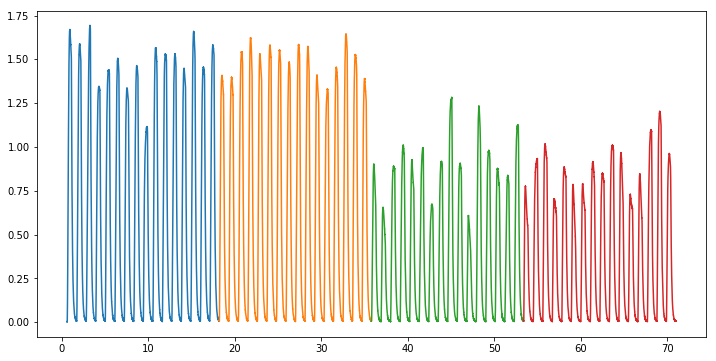

In [71]:
plt.figure(figsize=(12, 6))
plt.plot(t_range[fan1_win], output[fan1_win])
plt.plot(t_range[fan2_win], output[fan2_win])
plt.plot(t_range[foil1_win], output[foil1_win])
plt.plot(t_range[foil2_win], output[foil2_win])

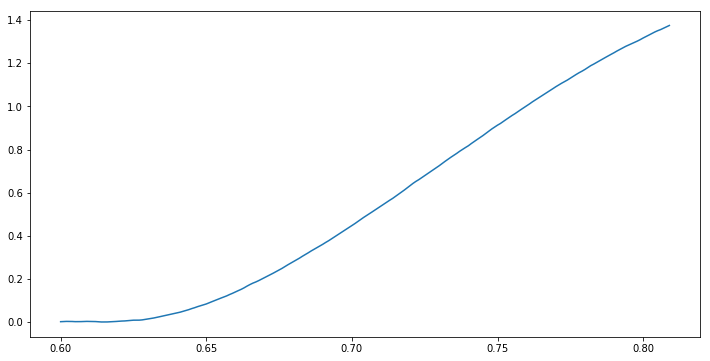

In [14]:
plt.figure(figsize=(12, 6))
plt.plot(t_range[600:810], output[600:810])

In [15]:
all_vecs = vocab.parse("+".join(list(vocab.keys()))).v
all_vecs = all_vecs / np.linalg.norm(all_vecs)

In [44]:
inp[:100].shape

(100, 32)

In [47]:
f1_start = 1000
f2_start = fan2_win.start + 400

in_noise = all_vecs - inp
print(np.dot(inp[f1_start], accum[f1_start]))
print(np.dot(in_noise[f1_start], accum[f1_start]))
print(np.dot(inp[f2_start], accum[f2_start]))
print(np.dot(in_noise[f2_start], accum[f2_start]))

4.529040314195999
-3.741631997183802
4.442243078715163
-1.6613115154758402


In [52]:
with h5py.File("../data/fami_ia_full.h5py", "r") as fi:
    noise_out = np.array(fi['noise_out'])
    clean_out = np.array(fi['clean_out'])

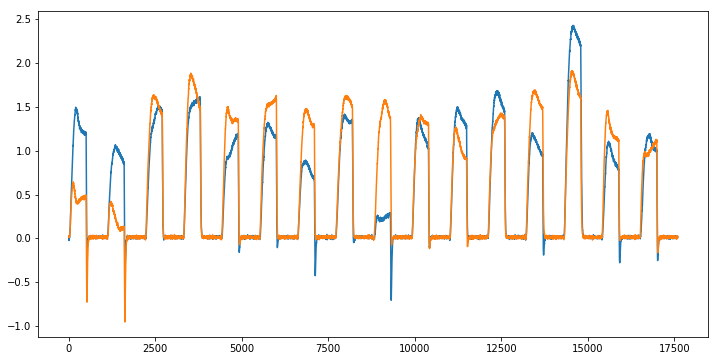

In [67]:
plt.figure(figsize=(12, 6))
#plt.plot(clean_out[fan1_win])
plt.plot(-noise_out[fan1_win])
#plt.plot(clean_out[fan2_win])
plt.plot(-noise_out[fan2_win])

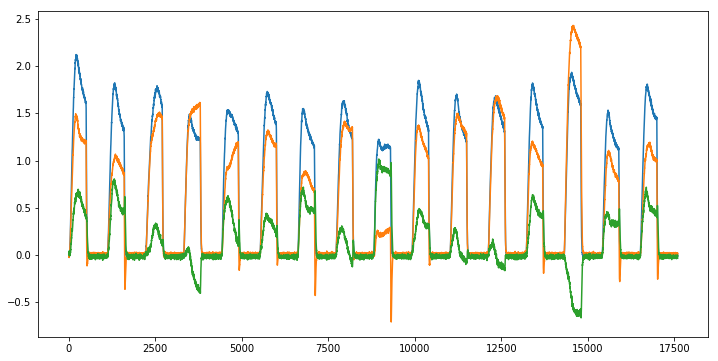

In [59]:
plt.figure(figsize=(12, 6))
plt.plot(clean_out[fan1_win])
plt.plot(-noise_out[fan1_win])
plt.plot((clean_out+noise_out)[fan1_win])

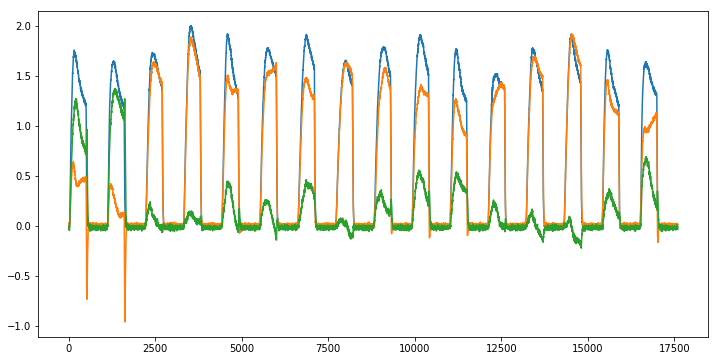

In [58]:
plt.figure(figsize=(12, 6))
plt.plot(clean_out[fan2_win])
plt.plot(-noise_out[fan2_win])
plt.plot((clean_out+noise_out)[fan2_win])

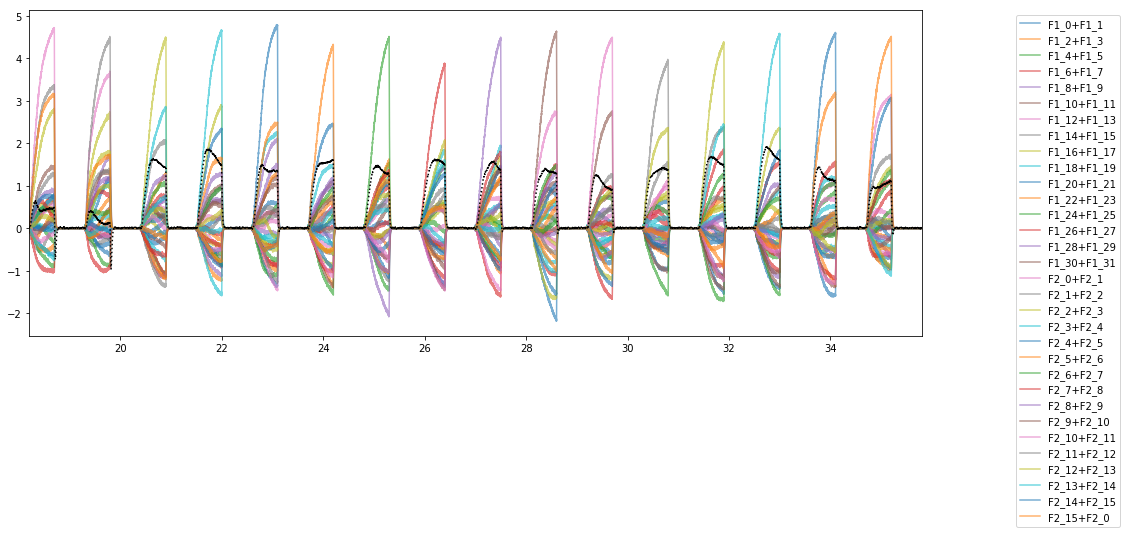

In [65]:
plt.figure(figsize=(16, 6))
plt.plot(t_range[fan2_win], spa.similarity(accum, fan1_pair_vecs+fan2_pair_vecs)[fan2_win], alpha=0.6)
plt.legend(fan1+fan2, bbox_to_anchor=(1.1, 1))
plt.xlim(fan2_win.start*dt, fan2_win.stop*dt)
plt.plot(t_range[fan2_win], -noise_out[fan2_win], color='k', linestyle=":")

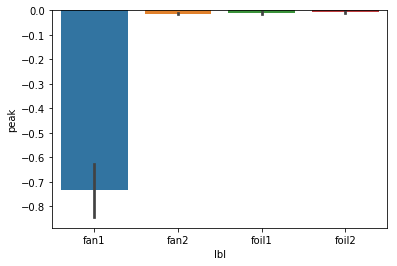

In [108]:
fan1_peak_idx = np.arange(int((t_pause+0.1)/dt), fan1_win.stop, int(t_each/dt))
fan2_peak_idx = np.arange(fan1_win.stop+int((t_pause+0.1)/dt), fan2_win.stop, int(t_each/dt))
foil1_peak_idx = np.arange(fan2_win.stop+int((t_pause+0.1)/dt), foil1_win.stop, int(t_each/dt))
foil2_peak_idx = np.arange(foil1_win.stop+int((t_pause+0.1)/dt), foil2_win.stop, int(t_each/dt))

peak_indices = (fan1_peak_idx, fan2_peak_idx, foil1_peak_idx, foil2_peak_idx)
labels = ("fan1", "fan2", "foil1", "foil2")

pk_list = []
peak_lbl = []
for lbl, idx in zip(labels, peak_indices):
    pk_list.append(noise_out[idx])
    peak_lbl.extend([lbl] * len(idx))

all_peaks = np.concatenate(pk_list, axis=0).flatten()

pd_peak = pd.DataFrame({"peak": all_peaks, "lbl": peak_lbl})
sns.barplot(x="lbl", y="peak", data=pd_peak)

(18.2, 35.800000000000004)

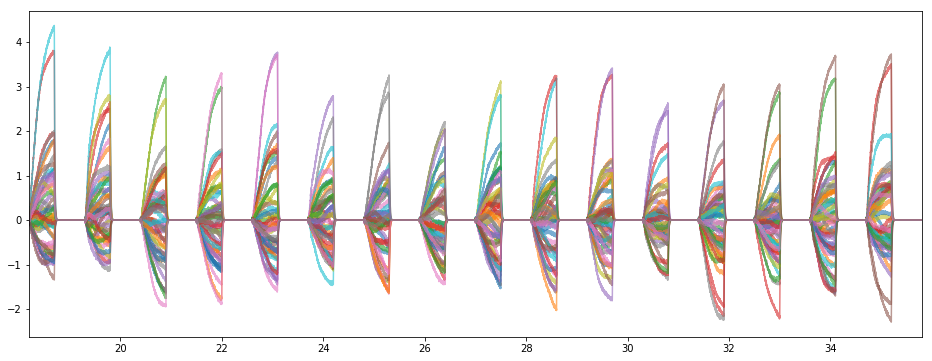

In [109]:
plt.figure(figsize=(16, 6))
plt.plot(t_range[fan2_win], spa.similarity(accum, vocab)[fan2_win], alpha=0.6)
plt.xlim(fan2_win.start*dt, fan2_win.stop*dt)

(0.6, 18.2)

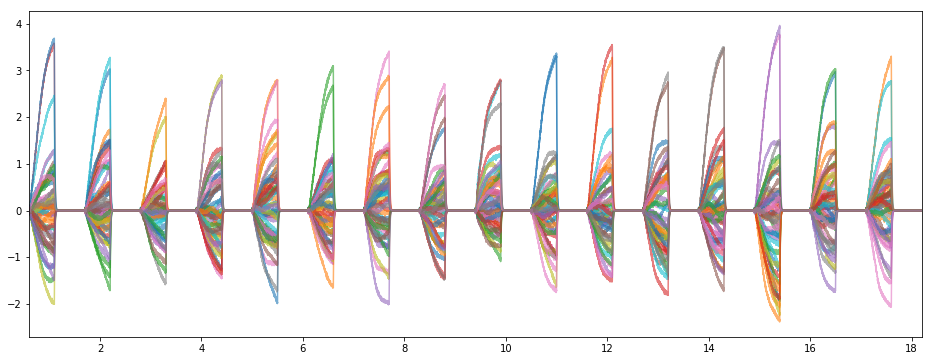

In [110]:
plt.figure(figsize=(16, 6))
plt.plot(t_range[fan1_win], spa.similarity(accum, vocab)[fan1_win], alpha=0.6)
plt.xlim(fan1_win.start*dt, fan1_win.stop*dt)

# Error Rate

FAN1 should be more accurate than FAN2. Should be no difference between FAN and FOIL.